### You are the fifth employee at company XYZ. The good news is that if the company becomes big, you will become very rich with the stocks. The bad news is that, at such an early stage, the data is usually very messy. All their data is stored in json files.

### The company CEO asked you very specific questions:

#### (1) What are the top 3 and the bottom 3 states in terms of number of users?

#### (2) What are the top 3 and the bottom 3 states in terms of user engagement? You can choose how to mathematically define user engagement. What the CEO cares about here is in which states users are using the product a lot/very little.

#### (3) The CEO wants to send a gift to the first user who signed-up for each state. That is, the first user who signed-up from California, from Oregon, etc. Can you give him a list of those users?

#### (4) Build a function that takes as an input any of the songs in the data and returns the most likely song to be listened next. That is, if, for instance, a user is currently listening to "Eight Days A Week", which song has the highest probability of being played right after it by the same user? This is going to be v1 of a song recommendation model.

#### (5) How would you set up a test to check whether your model works well and is improving engagement?

### Load the package would be used

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)

import seaborn as sns
import matplotlib.pyplot as plt

import random

### Read in the data set

In [2]:
dat = pd.read_json("../Datasets/song.json")

### Look into dataset

In [3]:
print(dat.shape)
print(dat.info)
print(len(dat["id"]) == len(pd.unique(dat["id"])))

(4000, 6)
<bound method DataFrame.info of               id  user_id  user_state user_sign_up_date                            song_played          time_played
0     GOQMMKSQQH      122   Louisiana        2015-05-16                               Hey Jude  2015-06-11 21:51:35
1     HWKKBQKNWI        3        Ohio        2015-05-01                     We Can Work It Out  2015-06-06 16:49:19
2     DKQSXVNJDH       35  New Jersey        2015-05-04                   Back In the U.S.S.R.  2015-06-14 02:11:29
3     HLHRIDQTUW      126    Illinois        2015-05-16                        P.s. I Love You  2015-06-08 12:26:10
4     SUKJCSBCYW        6  New Jersey        2015-05-01  Sgt. Pepper's Lonely Hearts Club Band  2015-06-28 14:57:00
...          ...      ...         ...               ...                                    ...                  ...
3995  MKVEXMRJGF      122   Louisiana        2015-05-16                       Paperback Writer  2015-06-03 08:26:26
3996  HMBEUWPBQI       76    N

In [4]:
dat["user_sign_up_date"] = pd.to_datetime(dat["user_sign_up_date"])
dat["time_played"] = pd.to_datetime(dat["time_played"])
dat.head()

,id,user_id,user_state,user_sign_up_date,song_played,time_played
0,GOQMMKSQQH,122,Louisiana,2015-05-16,Hey Jude,2015-06-11 21:51:35
1,HWKKBQKNWI,3,Ohio,2015-05-01,We Can Work It Out,2015-06-06 16:49:19
2,DKQSXVNJDH,35,New Jersey,2015-05-04,Back In the U.S.S.R.,2015-06-14 02:11:29
3,HLHRIDQTUW,126,Illinois,2015-05-16,P.s. I Love You,2015-06-08 12:26:10
4,SUKJCSBCYW,6,New Jersey,2015-05-01,Sgt. Pepper's Lonely Hearts Club Band,2015-06-28 14:57:00


#### (1) What are the top 3 and the bottom 3 states in terms of number of users?

In [5]:
grp_state = dat[["user_state", "user_id"]].groupby("user_state")["user_id"].nunique().reset_index()
print(grp_state.sort_values(by = ["user_id"], ascending = False)[0:3])
print(grp_state.sort_values(by = ["user_id"])[0:3])

    user_state  user_id
25    New York       23
4   California       21
35       Texas       15
     user_state  user_id
2       Arizona        1
24   New Mexico        1
6   Connecticut        1


### (2) What are the top 3 and the bottom 3 states in terms of user engagement? You can choose how to mathematically define user engagement. What the CEO cares about here is in which states users are using the product a lot/very little.

{'whiskers': [<matplotlib.lines.Line2D at 0x11c8053d0>,
 'caps': [<matplotlib.lines.Line2D at 0x11c805a60>,
 'boxes': [<matplotlib.lines.Line2D at 0x11c8053a0>],
 'medians': [<matplotlib.lines.Line2D at 0x11c895430>],
 'fliers': [<matplotlib.lines.Line2D at 0x11c805340>],
 'means': []}

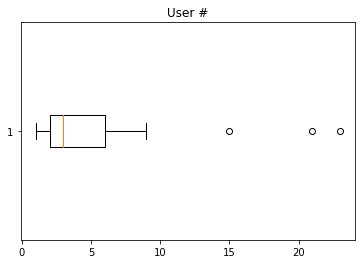

In [6]:
boxplot, ax = plt.subplots()
ax.set_title("User #")
ax.boxplot(grp_state["user_id"], vert = False)

In [7]:
grp_state_over3 = grp_state[grp_state["user_id"] >= 3]
song_over3 = dat[dat["user_state"].isin(grp_state_over3["user_state"])]

In [8]:
song_over3 = pd.DataFrame(song_over3)
grp_engage = song_over3[["id", "user_state", "user_id"]].groupby(["user_state", "user_id"])["id"].count().reset_index()
grp_avg_engage = grp_engage[["id", "user_state"]].groupby("user_state")["id"].mean().reset_index()
print(grp_avg_engage.sort_values(by = ["id"], ascending = False)[0:3])
print(grp_avg_engage.sort_values(by = ["id"])[0:3])

        user_state         id
13     Mississippi  28.333333
21  South Carolina  28.333333
7         Kentucky  26.000000
       user_state         id
12      Minnesota  10.500000
24  West Virginia  12.666667
6         Indiana  13.750000


#### (3) The CEO wants to send a gift to the first user who signed-up for each state. That is, the first user who signed-up from California, from Oregon, etc. Can you give him a list of those users?

In [9]:
grp_uni_first = dat[["user_state", "user_sign_up_date", "user_id"]].groupby("user_state")["user_sign_up_date"].min().reset_index()
grp_first = pd.merge(dat, grp_uni_first, on = ["user_state", "user_sign_up_date"])[["user_state", "user_sign_up_date", "user_id"]].drop_duplicates(["user_id"])
print(len(grp_uni_first))
print(len(grp_first))

41
51


#### (4) Build a function that takes as an input any of the songs in the data and returns the most likely song to be listened next. That is, if, for instance, a user is currently listening to "Eight Days A Week", which song has the highest probability of being played right after it by the same user? This is going to be v1 of a song recommendation model.

##### Step 1: Build a data set where for each user and song, it gives the next song listened to; order the data set by user_id and the time_played

In [10]:
user_song = dat[["user_id", "time_played", "song_played"]].sort_values(by = ["user_id", "time_played"])
user_song = user_song.reset_index(drop = True)

##### Step 2: Construct the recommendation system whose input is any of the songs in the data and the output is the most likely song to be listened next.

In [11]:
def song_recommend(song_df, song_listened_now): 
    """The function has two arguments:"""
    """song_df is the data frame including user_id, song_played and the timestamp."""
    """song_listened_now is any of the songs in the data frame"""
    if (song_listened_now not in song_df[["song_played"]].values):
        print("Error: The song is not in the system \n Input another song @_@")
    else:
        song_next = song_df.loc[song_df.loc[song_df["song_played"] == song_listened_now].index + 1]
        fil = song_next[song_next["user_id"].isin(song_df[song_df["song_played"] == song_listened_now]["user_id"])]
        song_next_freq = fil[["song_played", "time_played"]].groupby("song_played")["time_played"].count().reset_index()
        song_next_freq_sort = song_next_freq.sort_values(by = "time_played", ascending = False)
        song_next_freq_sort = song_next_freq_sort.reset_index(drop = True)
        """To see if tied tops exist; if so, generate a random number to give a recommendation"""
        n_tops = sum(song_next_freq_sort[0:1]["time_played"].isin(song_next_freq["time_played"]))
        sample = random.randrange(n_tops)
        return(song_next_freq_sort["song_played"][sample])

##### Step 3: Test the algorithm

In [12]:
song_recommend(song_df = user_song, song_listened_now = "Eight Days A Week")

'Come Together'

In [13]:
song_recommend(song_df = user_song, song_listened_now = "Eight Days a Week")

Error: The song is not in the system 
 Input another song @_@
